In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
path = kagglehub.dataset_download("thedevastator/online-course-student-engagement-metrics")

print(path)

/kaggle/input/online-course-student-engagement-metrics


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv("Courses.csv")

for column in df.columns:
    print(f"Column '{column}': {df[column].dtype}")

Column 'index': int64
Column 'course_id': object
Column 'userid_DI': object
Column 'registered': int64
Column 'viewed': int64
Column 'explored': int64
Column 'certified': int64
Column 'final_cc_cname_DI': object
Column 'LoE_DI': object
Column 'YoB': float64
Column 'gender': object
Column 'grade': object
Column 'start_time_DI': object
Column 'last_event_DI': object
Column 'nevents': float64
Column 'ndays_act': float64
Column 'nplay_video': float64
Column 'nchapters': float64
Column 'nforum_posts': int64
Column 'roles': float64
Column 'incomplete_flag': float64


In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
df = df.drop(columns=categorical_cols)

for col in df.columns:
    percentage_nan = (df[col].isna().sum() / len(df)) * 100
    print(f"Column '{col}': {percentage_nan:.2f}% NaN values")

Column 'index': 0.00% NaN values
Column 'registered': 0.00% NaN values
Column 'viewed': 0.00% NaN values
Column 'explored': 0.00% NaN values
Column 'certified': 0.00% NaN values
Column 'YoB': 15.07% NaN values
Column 'nevents': 31.06% NaN values
Column 'ndays_act': 25.38% NaN values
Column 'nplay_video': 71.36% NaN values
Column 'nchapters': 40.36% NaN values
Column 'nforum_posts': 0.00% NaN values
Column 'roles': 100.00% NaN values
Column 'incomplete_flag': 84.38% NaN values


In [ ]:
df = df.drop(columns=['roles'])

In [ ]:
for col in df.columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mean())
print(len(df))

641138


In [ ]:
X = X.dropna()
y = y.loc[X.index]


In [ ]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


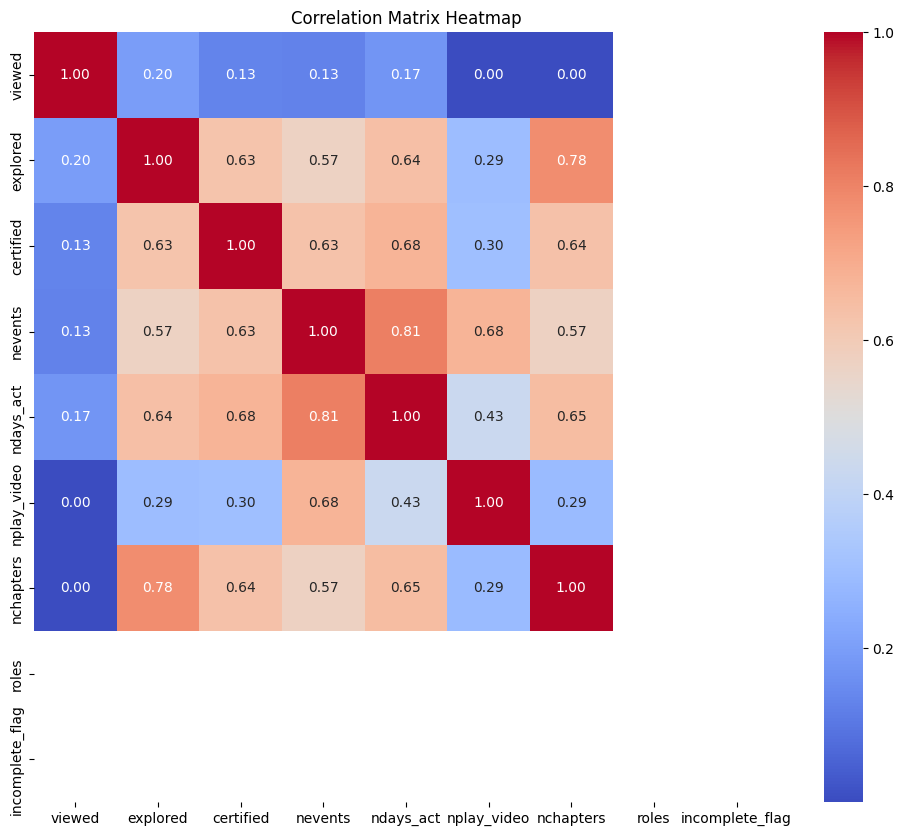

In [ ]:
correlation_matrix = df.corr()

columns_to_drop = []
for col in correlation_matrix.columns:
    if abs(correlation_matrix[col]).max() < 0.3:
        columns_to_drop.append(col)
df = df.drop(columns=columns_to_drop)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

Metodologia: stratified k fold cross validation para escolha de modelo e avaliação de desempenho, e grid search  para escolha de hiperparâmetros, ambos sklearn)


    Avalia múltiplos modelos com ajuste de hiperparâmetros usando Grid Search e validação cruzada.
    
    Parâmetros:
    - modelos (dict): Dicionário com os modelos { 'nome': modelo_base }.
    - parametros (dict): Dicionário com os hiperparâmetros { 'nome': { 'param1': [...], 'param2': [...] } }.
    - X (DataFrame): Features.
    - y (Series): Rótulo.
    - k (int): Número de folds na validação cruzada.
    
    Retorna:
    - DataFrame com as melhores métricas de cada modelo.

    


In [ ]:
def avaliar_modelos_com_random_search(modelos, parametros, X, y, k=2, n_iter=3):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    resultados = []

    for nome, modelo in modelos.items():
        print(f"Ajustando hiperparâmetros para: {nome} ...")

        random_search = RandomizedSearchCV(
            modelo,
            parametros[nome],
            cv=skf,
            scoring='f1',
            n_iter=n_iter,
            n_jobs=-1,
            verbose=2,
            random_state=42
        )
        random_search.fit(X, y)

        melhor_modelo = random_search.best_estimator_
        melhores_parametros = random_search.best_params_
        print(f"Melhor configuração para {nome}: {melhores_parametros}")

        y_pred = melhor_modelo.predict(X)

        resultados.append({
            'Modelo': nome,
            'Melhores Parâmetros': melhores_parametros,
            'Acurácia': accuracy_score(y, y_pred),
            'Precisão': precision_score(y, y_pred, average='binary'),
            'Recall': recall_score(y, y_pred, average='binary'),
            'F1-Score': f1_score(y, y_pred, average='binary')
        })

    df_resultados = pd.DataFrame(resultados).sort_values(by="F1-Score", ascending=False)
    return df_resultados

parametros = {
    "Random Forest": {
        'n_estimators': [50, 100],
        'max_depth': [None, 10],
        'min_samples_split': [2]
    },
    "Regressão Logística": {
        'logreg__C': [0.1, 1],
        'logreg__solver': ['liblinear']
    }
}

modelos = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Regressão Logística": Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('logreg', LogisticRegression(random_state=42))
    ])
}

X = df.drop(columns=['certified'])
y = df['certified']

resultado_modelos = avaliar_modelos_com_random_search(modelos, parametros, X, y, k=2, n_iter=3)
print(resultado_modelos)


Ajustando hiperparâmetros para: Random Forest ...
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Melhor configuração para Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 10}
Ajustando hiperparâmetros para: Regressão Logística ...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=3. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['roles']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Melhor configuração para Regressão Logística: {'logreg__solver': 'liblinear', 'logreg__C': 1}
                Modelo                                Melhores Parâmetros  \
0        Random Forest  {'n_estimators': 100, 'min_samples_split': 2, ...   
1  Regressão Logística    {'logreg__solver': 'liblinear', 'logreg__C': 1}   

   Acurácia  Precisão    Recall  F1-Score  
0  0.988798  0.800229  0.791542  0.795862  
1  0.985446  0.768130  0.676712  0.719529  


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['roles']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [ ]:
melhor_modelo_rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=2,
    max_depth=10,
    random_state=42
)

melhor_modelo_rf.fit(X, y)


RandomForestClassifier(max_depth=10, random_state=42)